In [1]:
%matplotlib widget


import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy.visualization import simple_norm, imshow_norm
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core import rss, image, spectrum1d, tracemask

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")
out_arc_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{lamps}.fits")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
# bias and darks

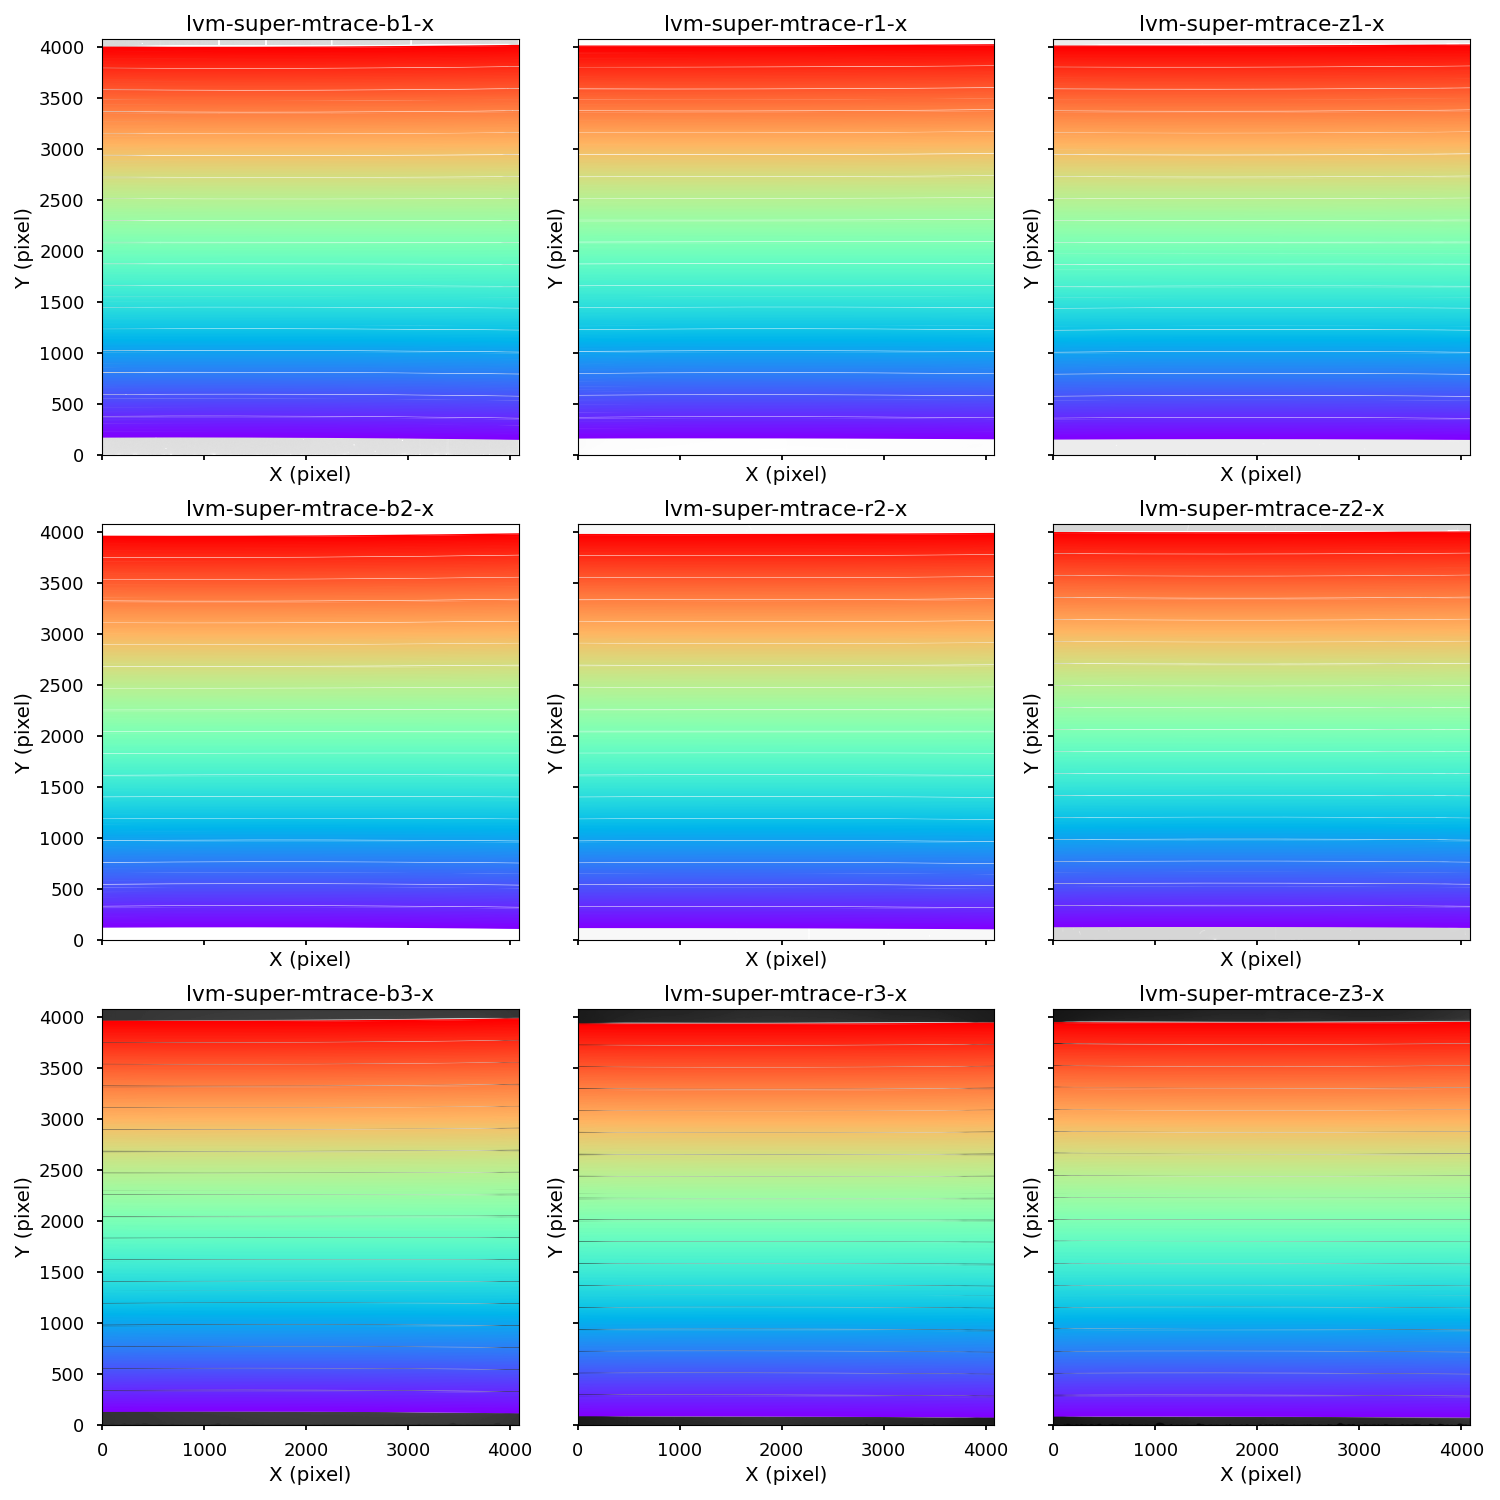

In [5]:
# tracing
traces = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mtrace", exptime="x").sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex=True, sharey=True)
axs = axs.T.flatten()

for i, ax in enumerate(axs):
    trace_path = traces.path.iloc[i]
    
    ax.set_title(os.path.basename(trace_path).replace(".fits", ""))
    ax.set_xlabel("X (pixel)")
    ax.set_ylabel("Y (pixel)")

    trace = tracemask.TraceMask()
    trace.loadFitsData(trace_path)

    fiberflat = image.loadImage(trace_path.replace("mtrace", "mfiberflat"))

    fiberflat_data = fiberflat._data
    # fiberflat_data[fiberflat._mask] = np.nan

    norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
    ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

    for ifiber in range(trace._fibers):
        fiber = trace.getSpec(ifiber)
        ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=1)

fig.tight_layout()

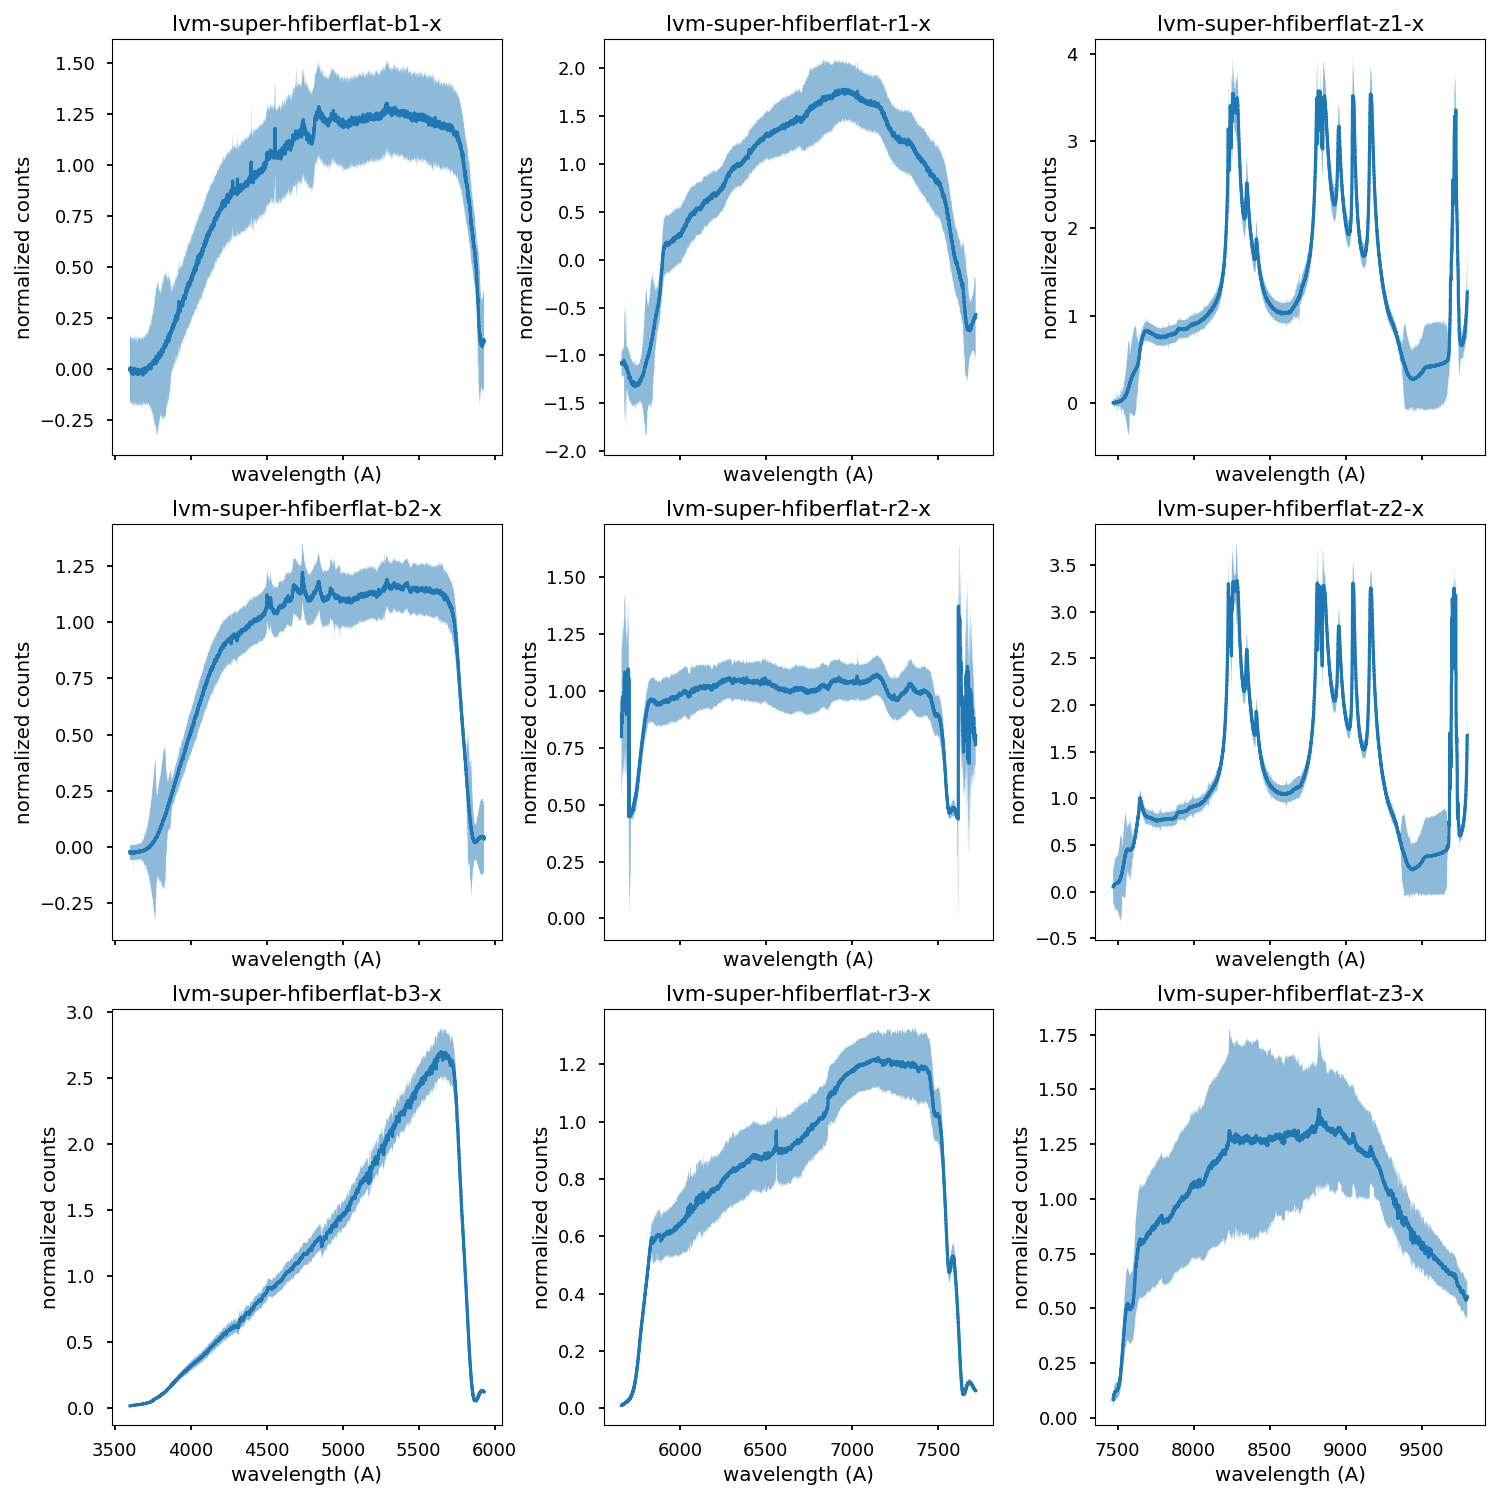

In [11]:
# fiberflats
fiberflats = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="hfiberflat", exptime="x").sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex="col", sharey=False)
axs = axs.T.flatten()
for i, ax in enumerate(axs):
    fiberflat_path = fiberflats.path.iloc[i]
    
    ax.set_title(os.path.basename(fiberflat_path).replace(".fits", ""))
    ax.set_xlabel("wavelength (A)")
    ax.set_ylabel("normalized counts")

    fiberflat = rss.RSS()
    fiberflat.loadFitsData(fiberflat_path)

    data = np.ma.masked_array(fiberflat._data, mask=fiberflat._mask)
    data = sigma_clip(data, sigma=3)
    data /= np.ma.median(data)

    flat_med = np.ma.median(data, axis=0)
    flat_std = np.ma.std(data, axis=0)
    
    ax.fill_between(fiberflat._wave, flat_med-flat_std, flat_med+flat_std, lw=0, fc="tab:blue", alpha=0.5)
    ax.step(fiberflat._wave, flat_med, color="tab:blue")

fig.tight_layout()

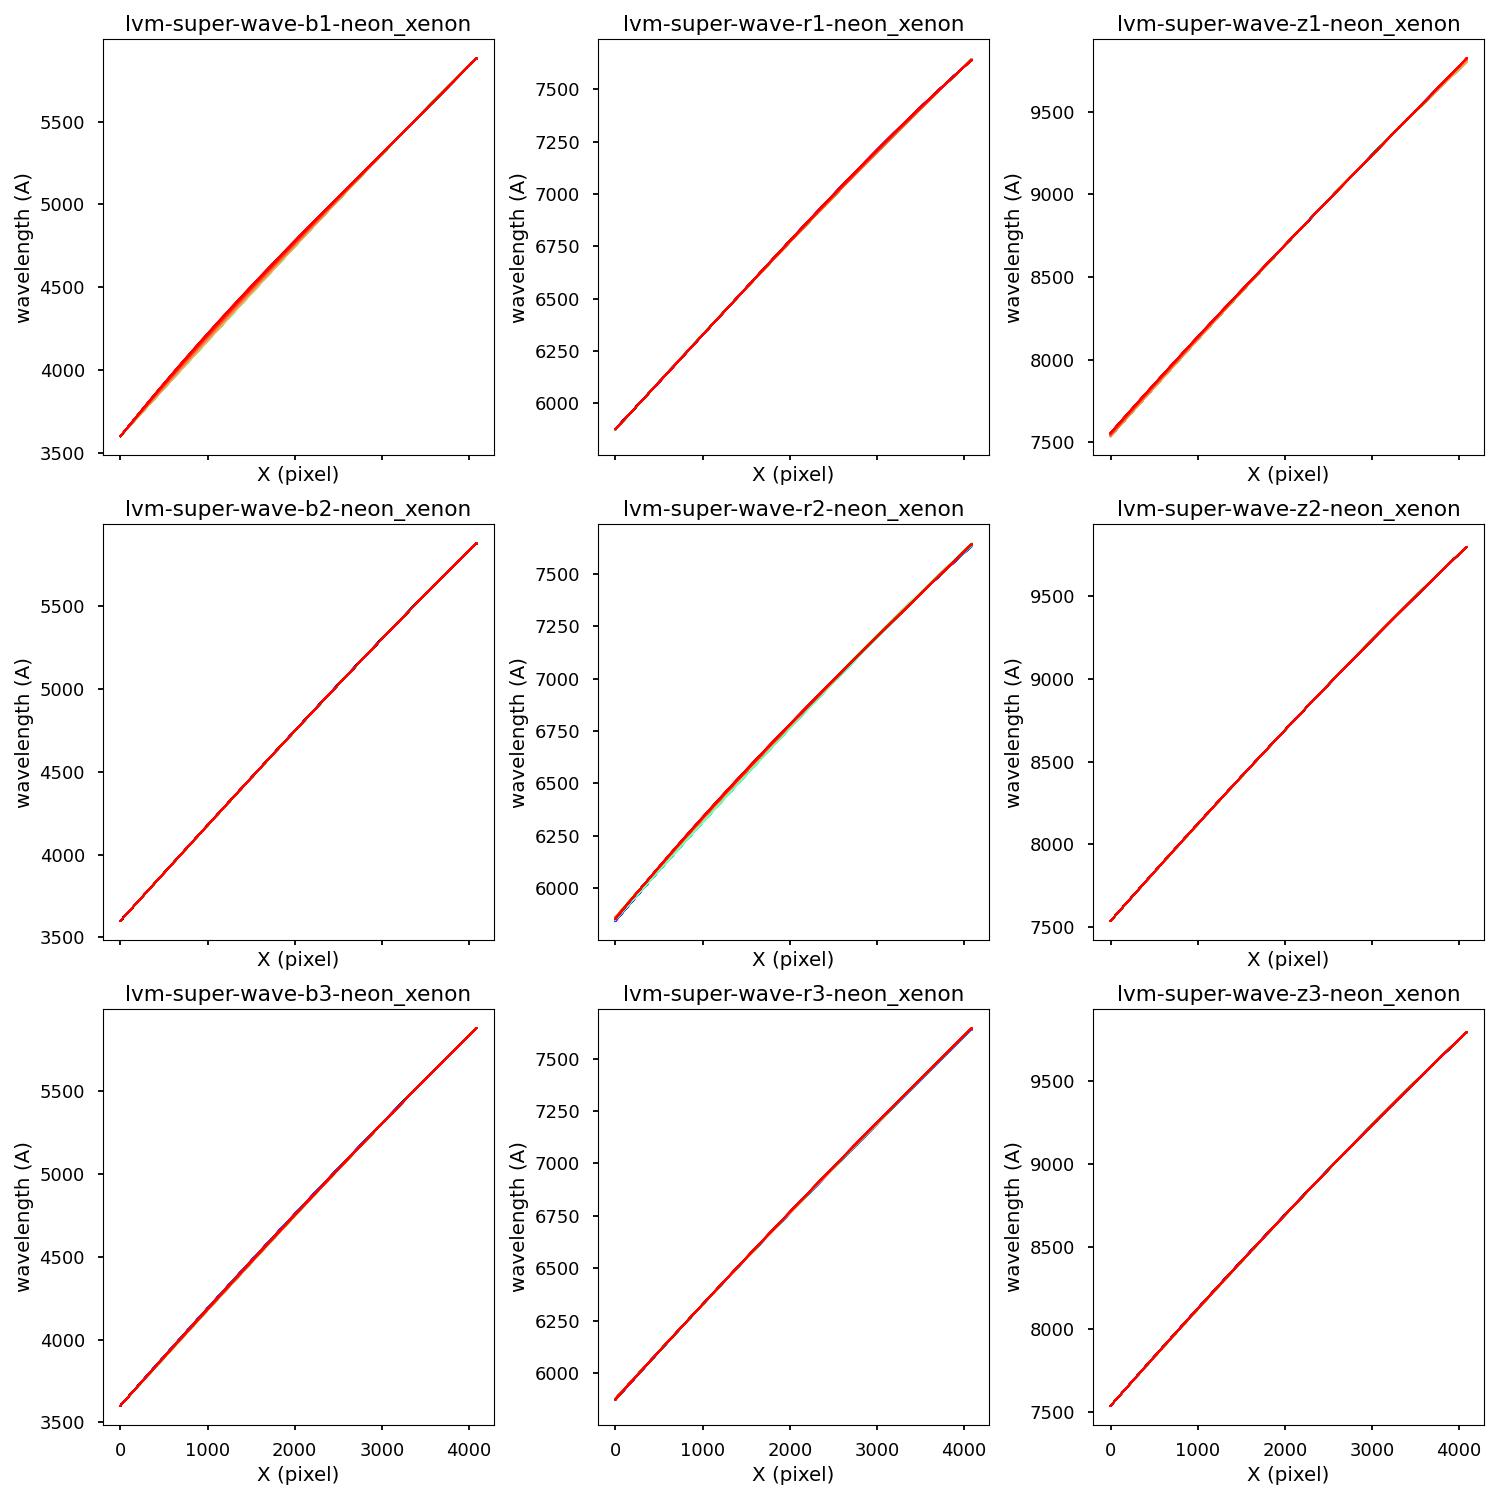

In [7]:
# arcs and wavelength solutions
from numpy.polynomial import Polynomial

lamps = "neon_xenon"

waves = get_masters_metadata(path_pattern=out_arc_path, mjd="super", kind="wave", lamps=lamps).sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex="col", sharey="col")
axs = axs.T.flatten()

wave_traces = {}
for i, ax in enumerate(axs):
    wave_path = waves.path.iloc[i]
    
    ax.set_title(os.path.basename(wave_path).replace(".fits", ""))
    ax.set_xlabel("X (pixel)")
    ax.set_ylabel("wavelength (A)")
    
    wave = tracemask.TraceMask()
    wave.loadFitsData(wave_path)
    
    wave_traces[waves.camera.iloc[i]] = wave._data

    for ifiber in range(wave._fibers):
        wave_trace = Polynomial(wave._coeffs[ifiber], domain=wave._pixels[[0,-1]])(wave._pixels)
        ax.step(wave._pixels, wave_trace, color=plt.cm.rainbow(ifiber/wave._fibers), lw=1)

fig.tight_layout()

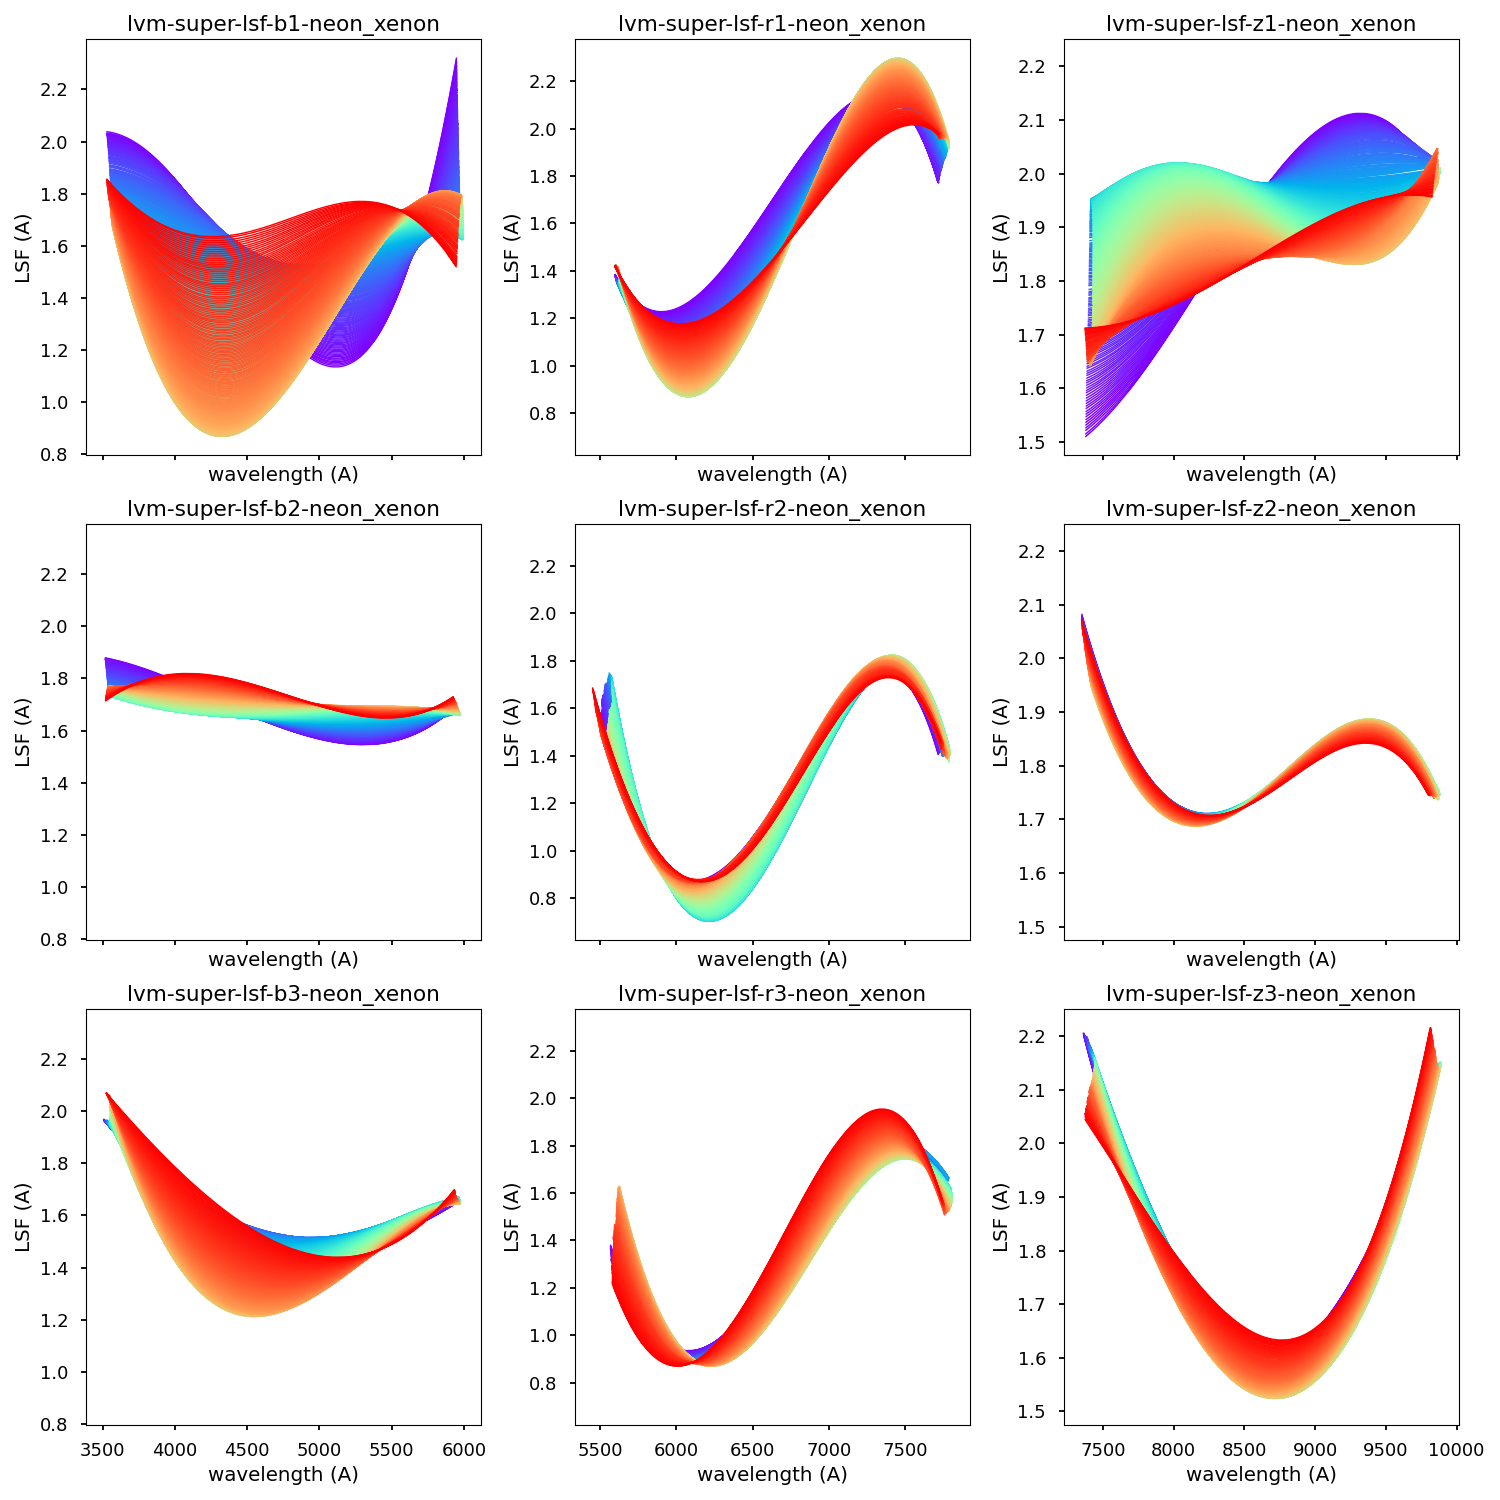

In [8]:
lsfs = get_masters_metadata(path_pattern=out_arc_path, mjd="super", kind="lsf", lamps=lamps).sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex="col", sharey="col")
axs = axs.T.flatten()

lsf_traces = {}
for i, ax in enumerate(axs):
    lsf_path = lsfs.path.iloc[i]
    
    ax.set_title(os.path.basename(lsf_path).replace(".fits", ""))
    ax.set_xlabel("wavelength (A)")
    ax.set_ylabel("LSF (A)")
    
    lsf = tracemask.TraceMask()
    lsf.loadFitsData(lsf_path)

    lsf_traces[waves.camera.iloc[i]] = lsf._data
    
    for ifiber in range(lsf._fibers):
        lsf_trace = Polynomial(lsf._coeffs[ifiber], domain=lsf._pixels[[0,-1]])(lsf._pixels)
        ax.step(wave_traces[lsfs.camera.iloc[i]][ifiber], lsf_trace, color=plt.cm.rainbow(ifiber/lsf._fibers), lw=1)

fig.tight_layout()

In [9]:
wave_ranges = pd.DataFrame({camera: np.median(wave, axis=0) for camera, wave in wave_traces.items()}).agg(["min","max"])
wave_ranges.loc["std", :] = pd.DataFrame({camera: np.median(wave, axis=1) for camera, wave in wave_traces.items()}).agg(["std"]).values
print(wave_ranges.to_string())

              b1           b2           b3           r1           r2           r3           z1           z2           z3
min  3566.397217  3546.983398  3545.866211  5621.335938  5551.477539  5619.446289  7415.814453  7407.708008  7425.446289
max  5980.448242  5958.398438  5960.825195  7769.825195  7771.633789  7784.515625  9868.054688  9858.794922  9866.980469
std     3.954278    12.490456    10.182521    16.634293    15.396942    16.353218    22.954050    23.400490    22.489388


In [10]:
lsf_ranges = pd.DataFrame({camera: np.median(lsf, axis=0) for camera, lsf in lsf_traces.items()}).agg(["min","max"])
lsf_ranges.loc["std", :] = pd.DataFrame({camera: np.median(lsf, axis=1) for camera, lsf in lsf_traces.items()}).agg(["std"]).values
print(lsf_ranges.to_string())

           b1        b2        b3        r1        r2        r3        z1        z2        z3
min  1.230620  1.662470  1.373809  0.968104  0.780766  0.886153  1.710509  1.701744  1.558684
max  1.793249  1.761130  2.047503  2.294593  3.153599  2.317996  2.034810  2.107076  2.240471
std  0.116043  0.028249  0.056860  0.021369  0.022932  0.025774  0.052833  0.003297  0.020199
